# Basismodell: Logistic regression

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


# Load data
df_model_data = pd.read_excel('../data/processed/PSP_model_data.xlsx')
df_fees = pd.read_excel('../data/raw/PSP_Fees.xlsx')

# Show the first few rows of each dataset to understand the structure
df_model_data.head(), df_fees.head()

# Merge the model data with the fees data
df_merged = pd.merge(df_model_data, df_fees, how='left', on=['PSP', 'success'])

# Show the first few rows of the merged dataset
df_merged.head()

,index,tmsp,country,amount,success,PSP,3D_secured,card,attempts,fee_x,...,time_of_day,fee_to_amount_ratio,log_amount,country_PSP,PSP_3D_secured,previous_successes,previous_failures,transaction_duration,amount_group,fee_y
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,1,1.0,...,Night,0.011236,4.499810,Germany_UK_Card,UK_Card_0,0,0,0,small,1.0
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,2,3.0,...,Night,0.033708,4.499810,Germany_UK_Card,UK_Card_0,1,0,0,small,3.0
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,1,1.0,...,Night,0.004202,5.476464,Germany_UK_Card,UK_Card_1,0,0,0,medium,1.0
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,2,3.0,...,Night,0.012605,5.476464,Germany_UK_Card,UK_Card_1,1,0,0,medium,3.0
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,1,0.5,...,Night,0.004032,4.828314,Austria_Simplecard,Simplecard_0,0,0,0,small,0.5


In [37]:
# Drop columns that won't be used in the model
drop_columns = ['index', 'tmsp', 'hour', 'attempts', 'fee_x', 'fee_to_amount_ratio', 'log_amount', 'previous_successes', 'previous_failures', 'transaction_duration', 'fee_y']
df_model = df_merged.drop(columns=drop_columns)

# Encode categorical variables
label_columns = ['country', 'PSP', 'card', 'weekday', 'time_of_day', 'country_PSP', 'PSP_3D_secured', 'amount_group']
label_encoder = LabelEncoder()
for col in label_columns:
    df_model[col] = label_encoder.fit_transform(df_model[col].astype(str))

# Split the data into training and test sets
X = df_model.drop('success', axis=1)
y = df_model['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show the first few rows of the scaled training data
pd.DataFrame(X_train_scaled, columns=X_train.columns).head()

,country,amount,PSP,3D_secured,card,weekday,time_of_day,country_PSP,PSP_3D_secured,amount_group
0,-0.015475,-0.647278,-0.248014,-0.561389,1.481725,-1.540419,-0.444938,-0.101105,-0.366451,1.218614
1,-0.015475,-0.470256,-0.248014,-0.561389,-0.057004,1.382030,0.446840,-0.101105,-0.366451,1.218614
2,1.564492,-0.626452,-2.373362,-0.561389,-0.057004,0.894955,0.446840,0.640776,-2.441463,1.218614
3,1.564492,0.748067,-0.248014,-0.561389,-0.057004,1.382030,-0.444938,1.382657,-0.366451,-1.235409
4,1.564492,-0.980494,-0.248014,-0.561389,-1.595733,-0.566269,-1.336716,1.382657,-0.366451,1.218614


In [38]:
# Initialize and train the logistic regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = log_reg_model.predict(X_test_scaled)

# Get the probabilities of success
y_prob = log_reg_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(accuracy)
print(conf_matrix)
print(class_report)

0.7970640745883754
[[8036    0]
 [2046    0]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      8036
           1       0.00      0.00      0.00      2046

    accuracy                           0.80     10082
   macro avg       0.40      0.50      0.44     10082
weighted avg       0.64      0.80      0.71     10082


/Users/christopheressmann/.conda/envs/bin/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christopheressmann/.conda/envs/bin/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christopheressmann/.conda/envs/bin/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

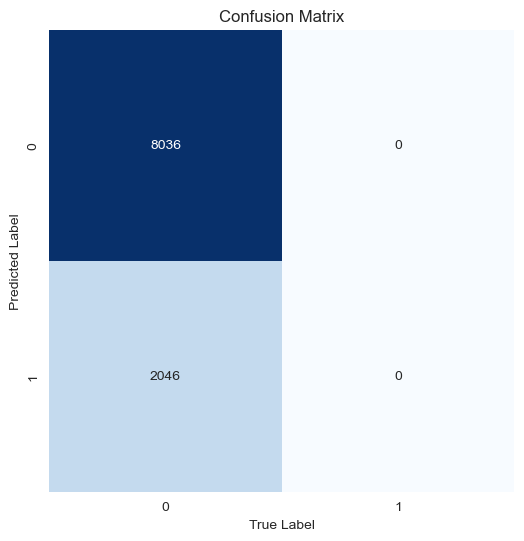

In [39]:
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix')
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Achsentitel hinzufügen
plt.xlabel('True Label')
plt.ylabel('Predicted Label')

plt.show()

# Feature importance

In [ ]:
# Get the feature importances from the logistic regression model
feature_importance = log_reg_model.coef_[0]

# Create a DataFrame for the feature importances
df_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sort the DataFrame by the importances
df_feature_importance = df_feature_importance.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(df_feature_importance['Feature'], df_feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Model')
plt.show()

# XGBoost classifier

In [75]:
# Drop columns that won't be used in the model
drop_columns = ['index', 'tmsp', 'hour', 'attempts', 'fee', 'fee_to_amount_ratio', 
                'log_amount', 'previous_successes', 'previous_failures', 'transaction_duration']
df_model = df_model_data.drop(columns=drop_columns)

# Encode categorical variables
label_columns = ['country', 'PSP', 'card', 'weekday', 'time_of_day', 
                 'country_PSP', 'PSP_3D_secured', 'amount_group']
label_encoder = LabelEncoder()
for col in label_columns:
    df_model[col] = label_encoder.fit_transform(df_model[col].astype(str))

# Split the data into training and test sets
X = df_model.drop('success', axis=1)
y = df_model['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [76]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Get the probabilities of success
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
class_report_xgb = classification_report(y_test, y_pred_xgb)

print(accuracy_xgb) 
print(conf_matrix_xgb)
print(class_report_xgb)

0.7936999127191938
[[9841  205]
 [2395  162]]
              precision    recall  f1-score   support

           0       0.80      0.98      0.88     10046
           1       0.44      0.06      0.11      2557

    accuracy                           0.79     12603
   macro avg       0.62      0.52      0.50     12603
weighted avg       0.73      0.79      0.73     12603


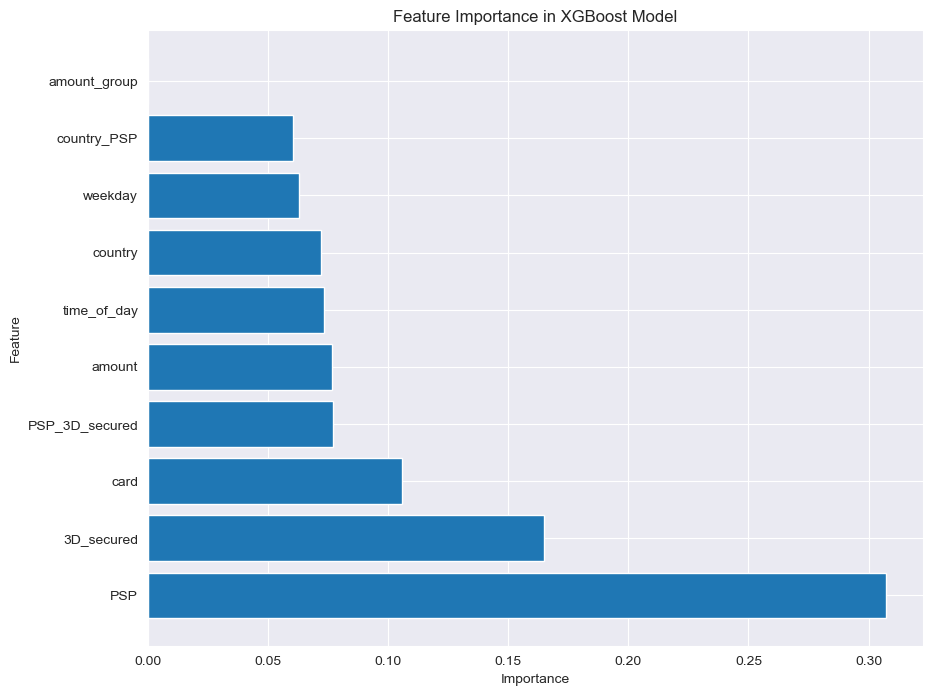

In [77]:
# Feature importance
# Get the feature importances from the XGBoost model
feature_importance_xgb = xgb_model.feature_importances_

# Create a DataFrame for the feature importances
df_feature_importance_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_xgb
})

# Sort the DataFrame by the importances
df_feature_importance_xgb = df_feature_importance_xgb.sort_values('Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(df_feature_importance_xgb['Feature'], df_feature_importance_xgb['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost Model')
plt.show()

# Prediction for real usecase

In [78]:
def replicate_dataframe_with_values(df, col, new_value):
    """
    Replicates the DataFrame df for each value in N and sets the 'PSP' column
    with the corresponding value.
    
    Parameters:
    - df: Original DataFrame
    - col: Name of the column to update
    - new_values: List or array of values to set in the specified column
    
    Returns:
    - concatenated_df: A DataFrame containing all the replicated DataFrames
    """
    dfs = []  # List to store the replicated DataFrames

    for value in new_value:
        new_df = df.copy()  # Create a copy of the original DataFrame
        new_df[col] = value  # Set the column with the new value
        dfs.append(new_df)  # Add the new DataFrame to the list

    # Concatenate all the replicated DataFrames into one
    concatenated_df = pd.concat(dfs, ignore_index=True)

    return concatenated_df

In [91]:
# Expand data for all PSP
X_test['ID'] = X_test.index
df_test_psp = replicate_dataframe_with_values(X_test, 'PSP', new_value=['UK_Card', 'Simplecard', 'Moneycard', 'Goldcard'])

# Merge the model data with the fees data
df_test_psp = pd.merge(df_test_psp, df_fees.loc[df_fees['success'] == 1, ['PSP','fee']], 
                       how='left', on='PSP')
df_test_psp['PSP_txt'] = df_test_psp['PSP']

# Prepare data for modelinput
df_test_psp['PSP'] = label_encoder.fit_transform(df_test_psp['PSP'].astype(str))

# Get the probabilities of success
df_test_psp['prob_xgb'] = xgb_model.predict_proba(df_test_psp.drop(columns=['ID', 'fee', 'PSP_txt']))[:, 1]

In [102]:
# Calculate expected value per ID
fee_factor = 0.1
df_test_psp['prob_fee_rario'] = ((1-fee_factor) * (1-df_test_psp['prob_xgb'])) + (fee_factor * df_test_psp['fee'] / 10)
df_test_psp[df_test_psp['ID'] == 3]

# Idee: prob_xgb mit einem Faktor anhand der Fee verändern -> Kann vom Fachbereich gesetzt werden
# Balance zwischen erfolgreichen Zahlungen und Gebühren

# Idee Controlling:
# Durchschnittliche Gebühren und Erfolg je Tag oder Woche
# Dann Vergleich mit neuem Modell
# Grafische Analyse + Signifikanz etc.

,country,amount,PSP,3D_secured,card,weekday,time_of_day,country_PSP,PSP_3D_secured,amount_group,ID,fee,PSP_txt,prob_xgb,prob_fee_rario
12,1,238,3,1,0,5,3,7,7,1,3,3.0,UK_Card,0.150714,0.794358
12615,1,238,2,1,0,5,3,7,7,1,3,1.0,Simplecard,0.202309,0.727922
25218,1,238,1,1,0,5,3,7,7,1,3,5.0,Moneycard,0.332409,0.650832
37821,1,238,0,1,0,5,3,7,7,1,3,10.0,Goldcard,0.590919,0.468173


SyntaxError: cannot assign to literal here. Maybe you meant '==' instead of '='? (3922340062.py, line 1)